# AlgebraicPetri Application Demo

[AlgebraicPetri.jl](https://algebraicjulia.github.io/AlgebraicPetri.jl/dev/) is a library which simultaneously provides modelers access to the model construction and analysis tools contained in [AlgebraicJulia](https://www.algebraicjulia.org/) and the simulation and analysis tools contained in [SciML](https://sciml.ai/).

In [1]:
# Necessary imports 
using AlgebraicPetri
using AlgebraicPetri.ModelComparison
using Semagrams, Semagrams.Examples
using Catlab
using Catlab.CategoricalAlgebra
using DifferentialEquations
using Plots
using JSON
using LabelledArrays
using PrettyTables

include("../src/GrometInterop.jl")
include("../src/ModelStratify.jl")
include("../src/Sensitivity.jl")
using .GrometInterop
using .ModelStratify
using .Sensitivity;

solution(model::LabelledReactionNet, tspan) = begin
    solve(ODEProblem(vectorfield(model), concentrations(model), tspan, rates(model)), Tsit5())
end
default(linewidth=5, xaxis="Time", yaxis="Population")
function sens_table(sens; kw...)
    sens_matrix = hcat(collect(keys(sens)), collect(values(sens)))
    pretty_table(sens_matrix[sortperm(sens_matrix[:, 2]; rev=true), :]; header=(["Transition", "Sensitivity"],), kw...)
end;
function signed_log(vals)
    scale_fac = 1.0/(minimum(abs.(vals)) + 1e-10)
    log_sens = log10.(abs.((vals .+ 1e-10) .* scale_fac)) .* sign.(vals)
end;
get_ptnet(a) = begin
    pn = get_acset(a)
    set_subparts!(pn, 1:nt(pn),
        rate=map(r->try parse(Float64, r) catch e;  (t...)->Base.invokelatest(eval(Meta.parse(r)), t...) end,
            subpart(pn, :rate)))
    pn
end

flt_rates(pn) = begin
    r = rates(pn)
    l = findall(t-> t isa Float64, r)
    Dict(zip(l, r[l]))
    @LArray r[l] Tuple(l)
end

function show_graph(g)
    display("text/html",html"<style>div.graphs svg{max-width:100% !important;max-height:100% !important;</style>")
    display("text/html", "<div class=graphs>" * read(Catlab.Graphics.Graphviz.run_graphviz(g, format = "svg"), String) * "</div>")
end;

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-14304502099167880188\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-16381116815549536803\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-14304502099167880188\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
@semagramschema LabelledReactionNetSema(TheoryLabelledReactionNet) begin
  @box S Circle label=:sname
  @box T Square label=:tname
  @wire I(is,it)
  @wire O(ot,os)
  @data Name Stringlike
  @data Rate Numeric
  @data Concentration Numeric
end;

In [3]:
p = Semagram{LabelledReactionNet{Union{Float64, String, Function}, Float64}}(LabelledReactionNetSema)

Semagram{Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:T, :S, :I, :O), (:it, :is, :ot, :os), (3, 3, 4, 4), (1, 2, 1, 2)}, Catlab.Theories.AttrDesc{Catlab.Theories.CatDesc{(:T, :S, :I, :O), (:it, :is, :ot, :os), (3, 3, 4, 4), (1, 2, 1, 2)}, (:Rate, :Concentration, :Name), (:rate, :concentration, :tname, :sname), (1, 2, 1, 2), (1, 2, 3, 3)}, Tuple{Union{Float64, Function, String}, Float64, Symbol}, (:is, :it, :os, :ot), (), Tables, Indices} where {Tables<:NamedTuple, Indices<:NamedTuple}}(WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}()), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("sending" => (Observable{Dict{String, Any}} with 2 listeners. Value:
Dict{String, Any}("sg" => Dict{String, Any}("gen" => Dict("i" => 0), "boxes" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[], "schema" => Dict{String, Dict}("box_types" => Dict{String, Dict{String, Any}}("S" => Dict("label" => "sname", "shape" => "<circle r=\"40\"></circle>", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[(Numeric, :concentration), (Stringlike, :sname)], "style_fn" => "(function (_){return {}})"), "T" => Dict("label" => "tname", "shape" => "<polygon points=\"-40,-40 40,-40 40,40 -40,40\"></polygon>", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[(Numeric, :rate), (Stringlike, :tname)], "style_fn" => "(function (_){return {}})")), "wire_types" => Dict{String, Dict{String, Any}}("I" => Dict("src_map" => "is", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[], "style" => "DefaultWire", "src" => (Semagrams.Schema.Box, :S), "tgt" => (Semagrams.Schema.Box, :T), "tgt_map" => "it", "style_fn" => "(function (_){return {}})"), "O" => Dict("src_map" => "ot", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[], "style" => "DefaultWire", "src" => (Semagrams.Schema.Box, :T), "tgt" => (Semagrams.Schema.Box, :S), "tgt_map" => "os", "style_fn" => "(function (_){return {}})")), "port_types" => Dict{Any, Any}()), "wires" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[]), "boxlocs" => Tuple{Int64, Tuple{Float64, Float64}}[]), nothing), "receiving" => (Observable{Dict{String, Any}} with 0 listeners. Value:
Dict{String, Any}("sg" => Dict{String, Any}("gen" => Dict("i" => 0), "boxes" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[], "schema" => Dict{String, Dict}("box_types" => Dict{String, Dict{String, Any}}("S" => Dict("label" => "sname", "shape" => "<circle r=\"40\"></circle>", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[(Numeric, :concentration), (Stringlike, :sname)], "style_fn" => "(function (_){return {}})"), "T" => Dict("label" => "tname", "shape" => "<polygon points=\"-40,-40 40,-40 40,40 -40,40\"></polygon>", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[(Numeric, :rate), (Stringlike, :tname)], "style_fn" => "(function (_){return {}})")), "wire_types" => Dict{String, Dict{String, Any}}("I" => Dict("src_map" => "is", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[], "style" => "DefaultWire", "src" => (Semagrams.Schema.Box, :S), "tgt" => (Semagrams.Schema.Box, :T), "tgt_map" => "it", "style_fn" => "(function (_){return {}})"), "O" => Dict("src_map" => "ot", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[], "style" => "DefaultWire", "src" => (Semagrams.Schema.Box, :T), "tgt" => (Semagrams.Schema.Box, :S), "tgt_map" => "os", "style_fn" => "(function (_){return {}})")), "port_types" => Dict{Any, Any}()), "wires" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[]), "boxlocs" => Tuple{Int64, Tuple{Float64, Float64}}[]), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "semagrams", "/Users/abaas3/.julia/dev/Semagrams/src/../deps/bundles/app.bundle.js")], Dict{Any, Any}("sending" => Any[WebIO.JSString("(function (newls){console.log(this); return this.state.resetWith(newls)})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runna

In [4]:
load(p, "SVIIR.sema");

In [5]:
model = get_ptnet(p)
show_graph(Graph(model, p; scale=144 * 0.8))

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.48.0 (20210717.1556)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- s1 -->
 
 s1 
 
 V 
 
<!-- t2 -->
 
 t2 
 
 β_{UV} 
 
<!-- s1->t2 -->
 
 s1->t2 
 
 
 1 
 
<!-- t4 -->
 
 t4 
 
 β_{VV} 
 
<!-- s1->t4 -->
 
 s1->t4 
 
 
 1 
 
<!-- s2 -->
 
 s2 
 
 S 
 
<!-- t1 -->
 
 t1 
 
 ν 
 
<!-- s2->t1 -->
 
 s2->t1 
 
 
 1 
 
<!-- t3 -->
 
 t3 
 
 β_{VU} 
 
<!-- s2->t3 -->
 
 s2->t3 
 
 
 1 
 
<!-- t7 -->
 
 t7 
 
 β_{UU} 
 
<!-- s2->t7 -->
 
 s2->t7 
 
 
 1 
 
<!-- s3 -->
 
 s3 
 
 R 
 
<!-- s4 -->
 
 s4 
 
 I_U 
 
<!-- s4->t2 -->
 
 s4->t2 
 
 
 1 
 
<!-- t5 -->
 
 t5 
 
 γ_U 
 
<!-- s4->t5 -->
 
 s4->t5 
 
 
 1 
 
<!-- s4->t7 -->
 
 s4->t7 
 
 
 1 
 
<!-- s5 -->
 
 s5 
 
 I_V 
 
<!-- s5->t3 -->
 
 s5->t3 
 
 
 1 
 
<!-- s5->t4 -->
 
 s5->t4 
 
 
 1 
 
<!-- t6 -->
 
 t6 
 
 γ_V 
 
<!-- s5->t6 -->
 
 s5->t6 
 
 
 1 
 
<!-- t1->s1 -->
 
 t1->s1 
 
 
 1 
 
<!-- t2->s4 -->
 
 t2->s4 
 
 
 1 
 
<!-- t2->s5 -->
 
 t2->s5 
 
 
 1 
 
<!-- t3->s4 -->
 
 t3->s4 
 
 
 1 
 
<!-- t3->s5 -->
 
 t3->s5 
 
 
 1 
 
<!-- t4->s5 -->
 
 t4->s5 
 
 
 2 
 
<!-- t5->s3 -->
 
 t5->s3 
 
 
 1 
 
<!-- t6->s3 -->
 
 t6->s3 
 
 
 1 
 
<!-- t7->s4 -->
 
 t7->s4 
 
 
 2

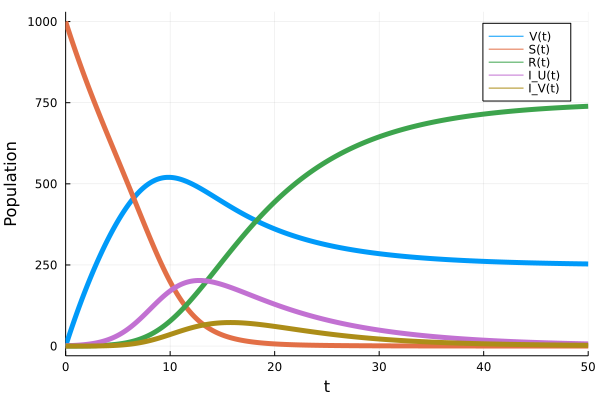

In [30]:
sol = solution(model, (0.0,50.0))
plot(sol)

In [9]:
int_met = Sensitivity.int_metric(model, [:R, :S, :V], t_range=(0.0,50.0))
sens = Sensitivity.sensitivity(int_met, flt_rates(model)) .* flt_rates(model) ./ int_met(flt_rates(model))
sens_table(sens)

┌────────────┬─────────────┐
│ Transition │ Sensitivity │
├────────────┼─────────────┤
│        γ_U │    0.101564 │
│          ν │   0.0961692 │
│        γ_V │   0.0363567 │
│     β_{VV} │ -0.00636655 │
│     β_{VU} │ -0.00815847 │
│     β_{UV} │  -0.0221078 │
│     β_{UU} │   -0.102475 │
└────────────┴─────────────┘


In [10]:
log_sens = signed_log(sens)
max_rng = maximum(abs.(log_sens))
show_graph(GraphHeatmap(model, log_sens, clims=(-max_rng, max_rng); positions=locations(model, save(p), scale=144 * 0.7)))

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.48.0 (20210717.1556)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- s1 -->
 
 s1 
 
 V 
 
<!-- t2 -->
 
 t2 
 
 β_{UV} 
 
<!-- s1->t2 -->
 
 s1->t2 
 
 
 1 
 
<!-- t4 -->
 
 t4 
 
 β_{VV} 
 
<!-- s1->t4 -->
 
 s1->t4 
 
 
 1 
 
<!-- s2 -->
 
 s2 
 
 S 
 
<!-- t1 -->
 
 t1 
 
 ν 
 
<!-- s2->t1 -->
 
 s2->t1 
 
 
 1 
 
<!-- t3 -->
 
 t3 
 
 β_{VU} 
 
<!-- s2->t3 -->
 
 s2->t3 
 
 
 1 
 
<!-- t7 -->
 
 t7 
 
 β_{UU} 
 
<!-- s2->t7 -->
 
 s2->t7 
 
 
 1 
 
<!-- s3 -->
 
 s3 
 
 R 
 
<!-- s4 -->
 
 s4 
 
 I_U 
 
<!-- s4->t2 -->
 
 s4->t2 
 
 
 1 
 
<!-- t5 -->
 
 t5 
 
 γ_U 
 
<!-- s4->t5 -->
 
 s4->t5 
 
 
 1 
 
<!-- s4->t7 -->
 
 s4->t7 
 
 
 1 
 
<!-- s5 -->
 
 s5 
 
 I_V 
 
<!-- s5->t3 -->
 
 s5->t3 
 
 
 1 
 
<!-- s5->t4 -->
 
 s5->t4 
 
 
 1 
 
<!-- t6 -->
 
 t6 
 
 γ_V 
 
<!-- s5->t6 -->
 
 s5->t6 
 
 
 1 
 
<!-- t1->s1 -->
 
 t1->s1 
 
 
 1 
 
<!-- t2->s4 -->
 
 t2->s4 
 
 
 1 
 
<!-- t2->s5 -->
 
 t2->s5 
 
 
 1 
 
<!-- t3->s4 -->
 
 t3->s4 
 
 
 1 
 
<!-- t3->s5 -->
 
 t3->s5 
 
 
 1 
 
<!-- t4->s5 -->
 
 t4->s5 
 
 
 2 
 
<!-- t5->s3 -->
 
 t5->s3 
 
 
 1 
 
<!-- t6->s3 -->
 
 t6->s3 
 
 
 1 
 
<!-- t7->s4 -->
 
 t7->s4 
 
 
 2

## Add a hypothesized transition to the original model

In [31]:
model_susc = get_ptnet(p)
show_graph(Graph(model_susc, p, scale = 144 * 0.7))

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.48.0 (20210717.1556)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- s1 -->
 
 s1 
 
 V 
 
<!-- t2 -->
 
 t2 
 
 β_{UV} 
 
<!-- s1->t2 -->
 
 s1->t2 
 
 
 1 
 
<!-- t4 -->
 
 t4 
 
 β_{VV} 
 
<!-- s1->t4 -->
 
 s1->t4 
 
 
 1 
 
<!-- s2 -->
 
 s2 
 
 S 
 
<!-- t1 -->
 
 t1 
 
 ν 
 
<!-- s2->t1 -->
 
 s2->t1 
 
 
 1 
 
<!-- t3 -->
 
 t3 
 
 β_{VU} 
 
<!-- s2->t3 -->
 
 s2->t3 
 
 
 1 
 
<!-- t8 -->
 
 t8 
 
 β_{UU} 
 
<!-- s2->t8 -->
 
 s2->t8 
 
 
 1 
 
<!-- s3 -->
 
 s3 
 
 R 
 
<!-- t5 -->
 
 t5 
 
 σ 
 
<!-- s3->t5 -->
 
 s3->t5 
 
 
 1 
 
<!-- s4 -->
 
 s4 
 
 I_U 
 
<!-- s4->t2 -->
 
 s4->t2 
 
 
 1 
 
<!-- t6 -->
 
 t6 
 
 γ_U 
 
<!-- s4->t6 -->
 
 s4->t6 
 
 
 1 
 
<!-- s4->t8 -->
 
 s4->t8 
 
 
 1 
 
<!-- s5 -->
 
 s5 
 
 I_V 
 
<!-- s5->t3 -->
 
 s5->t3 
 
 
 1 
 
<!-- s5->t4 -->
 
 s5->t4 
 
 
 1 
 
<!-- t7 -->
 
 t7 
 
 γ_V 
 
<!-- s5->t7 -->
 
 s5->t7 
 
 
 1 
 
<!-- t1->s1 -->
 
 t1->s1 
 
 
 1 
 
<!-- t2->s4 -->
 
 t2->s4 
 
 
 1 
 
<!-- t2->s5 -->
 
 t2->s5 
 
 
 1 
 
<!-- t3->s4 -->
 
 t3->s4 
 
 
 1 
 
<!-- t3->s5 -->
 
 t3->s5 
 
 
 1 
 
<!-- t4->s5 -->
 
 t4->s5 
 
 
 2 
 
<!-- t5->s2 -->
 
 t5->s2 
 
 
 1 
 
<!-- t6->s3 -->
 
 t6->s3 
 
 
 1 
 
<!-- t7->s3 -->
 
 t7->s3 
 
 
 1 
 
<!-- t8->s4 -->
 
 t8->s4 
 
 
 2

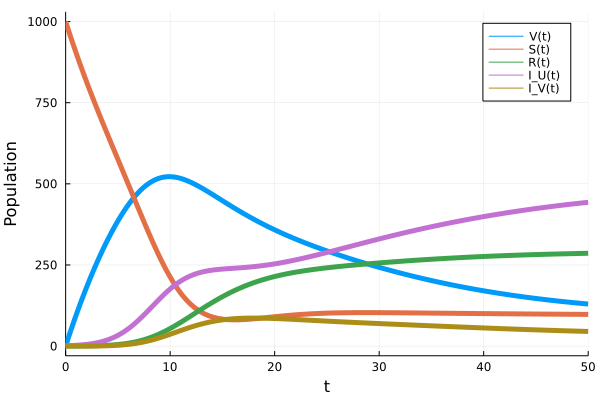

In [32]:
sol = solution(model_susc, (0.0, 50.0))
plot(sol)

In [17]:
int_met = int_metric(model_susc, [:R, :S, :V], t_range=(0.0,50.0))
sens = sensitivity(int_met, rates(model_susc)) .* rates(model_susc) ./ int_met(rates(model_susc))
sens_table(sens)

┌────────────┬─────────────┐
│ Transition │ Sensitivity │
├────────────┼─────────────┤
│          ν │    0.365404 │
│        γ_U │     0.34431 │
│        γ_V │   0.0910854 │
│     β_{VV} │  -0.0435335 │
│     β_{VU} │  -0.0587142 │
│          σ │     -0.1797 │
│     β_{UV} │   -0.190486 │
│     β_{UU} │   -0.560356 │
└────────────┴─────────────┘


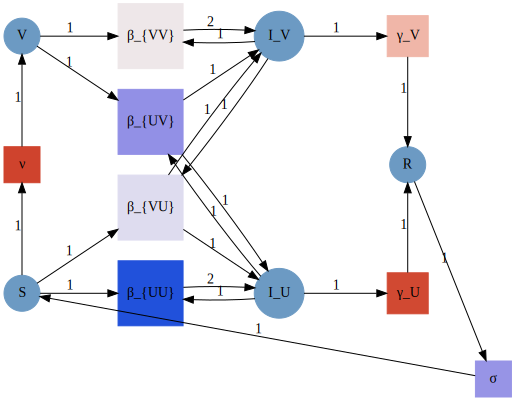

In [18]:
log_sens = signed_log(sens)
max_rng = maximum(abs.(log_sens))
GraphHeatmap(model_susc, log_sens; clims=(-max_rng, max_rng), positions=locations(model_susc, save(p), scale=144 * 0.7))

## Hypothesized stratification of model

### Specification of a Mixing Matrix

In [19]:
gen_graph = Semagram{ModelStratify.ScaleGraph{Float64, Symbol}}(ModelStratify.ScaleGraphSchema)

Semagram{Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:V, :E), (:src, :tgt), (2, 2), (1, 1)}, Catlab.Theories.AttrDesc{Catlab.Theories.CatDesc{(:V, :E), (:src, :tgt), (2, 2), (1, 1)}, (:Scale, :Label), (:edge_scale, :conc_scale, :rate_scale, :node_label), (2, 1, 1, 1), (1, 1, 1, 2)}, Tuple{Float64, Symbol}, (:src, :tgt), (), Tables, Indices} where {Tables<:NamedTuple, Indices<:NamedTuple}}(WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}()), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("sending" => (Observable{Dict{String, Any}} with 2 listeners. Value:
Dict{String, Any}("sg" => Dict{String, Any}("gen" => Dict("i" => 0), "boxes" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[], "schema" => Dict{String, Dict}("box_types" => Dict{String, Dict{String, Any}}("V" => Dict("label" => "node_label", "shape" => "<circle r=\"40\"></circle>", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[(Numeric, :conc_scale), (Numeric, :rate_scale), (Stringlike, :node_label)], "style_fn" => "(function (_){return {}})")), "wire_types" => Dict{String, Dict{String, Any}}("E" => Dict("src_map" => "src", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[(Numeric, :edge_scale)], "style" => "DefaultWire", "src" => (Semagrams.Schema.Box, :V), "tgt" => (Semagrams.Schema.Box, :V), "tgt_map" => "tgt", "style_fn" => "(function (_){return {}})")), "port_types" => Dict{Any, Any}()), "wires" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[]), "boxlocs" => Tuple{Int64, Tuple{Float64, Float64}}[]), nothing), "receiving" => (Observable{Dict{String, Any}} with 0 listeners. Value:
Dict{String, Any}("sg" => Dict{String, Any}("gen" => Dict("i" => 0), "boxes" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[], "schema" => Dict{String, Dict}("box_types" => Dict{String, Dict{String, Any}}("V" => Dict("label" => "node_label", "shape" => "<circle r=\"40\"></circle>", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[(Numeric, :conc_scale), (Numeric, :rate_scale), (Stringlike, :node_label)], "style_fn" => "(function (_){return {}})")), "wire_types" => Dict{String, Dict{String, Any}}("E" => Dict("src_map" => "src", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[(Numeric, :edge_scale)], "style" => "DefaultWire", "src" => (Semagrams.Schema.Box, :V), "tgt" => (Semagrams.Schema.Box, :V), "tgt_map" => "tgt", "style_fn" => "(function (_){return {}})")), "port_types" => Dict{Any, Any}()), "wires" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[]), "boxlocs" => Tuple{Int64, Tuple{Float64, Float64}}[]), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "semagrams", "/Users/abaas3/.julia/dev/Semagrams/src/../deps/bundles/app.bundle.js")], Dict{Any, Any}("sending" => Any[WebIO.JSString("(function (newls){console.log(this); return this.state.resetWith(newls)})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000017ecff0f0, Task (runnable) @0x000000017ecff0f0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("(function (){var semagrams=System.registry.get(System.resolveSync(\"semagrams\")); var scopeobj=this; return setTimeout((function (){return semagrams.main(WebIO.getval({\"name\":\"receiving\",\"scope\":\"1835812202220394110\",\"id\":\"3183146703247725991\",\"type\":\"observable\"}),scopeobj,(function (x){return WebIO.setval({\"name\":\"receiving\",\"scope\":\"1835812202220394110\",\"id\":\"3183146703247725991\",\"type\":\"observable\"},x)}))}),20)})")]), Observable{Dict{String, Any}} with 0 listeners. Value:
Dict{String, Any}("sg" => Dict{String, Any}("gen" => Dict("i" => 0), "boxes" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[], "schema" => Dict{String, Dict}("box_types" => Dict{String, Dict{String, Any}}("V" => Dict("label" => "node_label", "shape" => "<circle r=\"40\"></circle>", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[(Numeric, :conc_scale), 

In [20]:
load(gen_graph, "gen_graph.sema");

In [21]:
p_death = Semagram{LabelledReactionNet{Float64, Float64}}(LabelledReactionNetSema)

Semagram{Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:T, :S, :I, :O), (:it, :is, :ot, :os), (3, 3, 4, 4), (1, 2, 1, 2)}, Catlab.Theories.AttrDesc{Catlab.Theories.CatDesc{(:T, :S, :I, :O), (:it, :is, :ot, :os), (3, 3, 4, 4), (1, 2, 1, 2)}, (:Rate, :Concentration, :Name), (:rate, :concentration, :tname, :sname), (1, 2, 1, 2), (1, 2, 3, 3)}, Tuple{Float64, Float64, Symbol}, (:is, :it, :os, :ot), (), Tables, Indices} where {Tables<:NamedTuple, Indices<:NamedTuple}}(WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}()), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("sending" => (Observable{Dict{String, Any}} with 2 listeners. Value:
Dict{String, Any}("sg" => Dict{String, Any}("gen" => Dict("i" => 0), "boxes" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[], "schema" => Dict{String, Dict}("box_types" => Dict{String, Dict{String, Any}}("S" => Dict("label" => "sname", "shape" => "<circle r=\"40\"></circle>", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[(Numeric, :concentration), (Stringlike, :sname)], "style_fn" => "(function (_){return {}})"), "T" => Dict("label" => "tname", "shape" => "<polygon points=\"-40,-40 40,-40 40,40 -40,40\"></polygon>", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[(Numeric, :rate), (Stringlike, :tname)], "style_fn" => "(function (_){return {}})")), "wire_types" => Dict{String, Dict{String, Any}}("I" => Dict("src_map" => "is", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[], "style" => "DefaultWire", "src" => (Semagrams.Schema.Box, :S), "tgt" => (Semagrams.Schema.Box, :T), "tgt_map" => "it", "style_fn" => "(function (_){return {}})"), "O" => Dict("src_map" => "ot", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[], "style" => "DefaultWire", "src" => (Semagrams.Schema.Box, :T), "tgt" => (Semagrams.Schema.Box, :S), "tgt_map" => "os", "style_fn" => "(function (_){return {}})")), "port_types" => Dict{Any, Any}()), "wires" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[]), "boxlocs" => Tuple{Int64, Tuple{Float64, Float64}}[]), nothing), "receiving" => (Observable{Dict{String, Any}} with 0 listeners. Value:
Dict{String, Any}("sg" => Dict{String, Any}("gen" => Dict("i" => 0), "boxes" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[], "schema" => Dict{String, Dict}("box_types" => Dict{String, Dict{String, Any}}("S" => Dict("label" => "sname", "shape" => "<circle r=\"40\"></circle>", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[(Numeric, :concentration), (Stringlike, :sname)], "style_fn" => "(function (_){return {}})"), "T" => Dict("label" => "tname", "shape" => "<polygon points=\"-40,-40 40,-40 40,40 -40,40\"></polygon>", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[(Numeric, :rate), (Stringlike, :tname)], "style_fn" => "(function (_){return {}})")), "wire_types" => Dict{String, Dict{String, Any}}("I" => Dict("src_map" => "is", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[], "style" => "DefaultWire", "src" => (Semagrams.Schema.Box, :S), "tgt" => (Semagrams.Schema.Box, :T), "tgt_map" => "it", "style_fn" => "(function (_){return {}})"), "O" => Dict("src_map" => "ot", "homs" => Any[], "weights" => Tuple{AttributeType, Symbol}[], "style" => "DefaultWire", "src" => (Semagrams.Schema.Box, :T), "tgt" => (Semagrams.Schema.Box, :S), "tgt_map" => "os", "style_fn" => "(function (_){return {}})")), "port_types" => Dict{Any, Any}()), "wires" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[]), "boxlocs" => Tuple{Int64, Tuple{Float64, Float64}}[]), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "semagrams", "/Users/abaas3/.julia/dev/Semagrams/src/../deps/bundles/app.bundle.js")], Dict{Any, Any}("sending" => Any[WebIO.JSString("(function (newls){console.log(this); return this.state.resetWith(newls)})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000162290120,

In [22]:
# Add a death transition
load(p_death, "SVIIRD.sema");

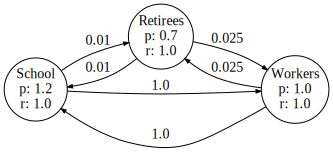

In [33]:
model_death = get_acset(p_death)
(generations = get_acset(gen_graph)) |> ModelStratify.show_graph

In [35]:
strat_model = ModelStratify.dem_strat(model_death, generations)
str_loc = ModelStratify.strat_location(strat_model, model_death, generations, locations(model_death, save(p_death), scale=144 * 0.4), locations(generations, save(gen_graph)), scale=1.4)
show_graph(Graph(strat_model, positions=str_loc))

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.48.0 (20210717.1556)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- s1 -->
 
 s1 
 
 V@School 
 
<!-- t3 -->
 
 t3 
 
 β_{UV}@School 
 
<!-- s1->t3 -->
 
 s1->t3 
 
 
 1 
 
<!-- t5 -->
 
 t5 
 
 β_{VV}@School 
 
<!-- s1->t5 -->
 
 s1->t5 
 
 
 1 
 
<!-- t36 -->
 
 t36 
 
 crx_V′_I_U_3_1 
 
<!-- s1->t36 -->
 
 s1->t36 
 
 
 1 
 
<!-- t38 -->
 
 t38 
 
 crx_V′_I_V_3_1 
 
<!-- s1->t38 -->
 
 s1->t38 
 
 
 1 
 
<!-- t44 -->
 
 t44 
 
 crx_V′_I_U_2_1 
 
<!-- s1->t44 -->
 
 s1->t44 
 
 
 1 
 
<!-- t46 -->
 
 t46 
 
 crx_V′_I_V_2_1 
 
<!-- s1->t46 -->
 
 s1->t46 
 
 
 1 
 
<!-- s2 -->
 
 s2 
 
 S@School 
 
<!-- t1 -->
 
 t1 
 
 ν@School 
 
<!-- s2->t1 -->
 
 s2->t1 
 
 
 1 
 
<!-- t4 -->
 
 t4 
 
 β_{VU}@School 
 
<!-- s2->t4 -->
 
 s2->t4 
 
 
 1 
 
<!-- t9 -->
 
 t9 
 
 β_{UU}@School 
 
<!-- s2->t9 -->
 
 s2->t9 
 
 
 1 
 
<!-- t37 -->
 
 t37 
 
 crx_S′_I_V_3_1 
 
<!-- s2->t37 -->
 
 s2->t37 
 
 
 1 
 
<!-- t39 -->
 
 t39 
 
 crx_S′_I_U_3_1 
 
<!-- s2->t39 -->
 
 s2->t39 
 
 
 1 
 
<!-- t45 -->
 
 t45 
 
 crx_S′_I_V_2_1 
 
<!-- s2->t45 -->
 
 s2->t45 
 
 
 1 
 
<!-- t47 -->
 
 t47 
 
 crx_S′_I_U_2_1 
 
<!-- s2->t47 -->
 
 s2->t47 
 
 
 1 
 
<!-- s3 -->
 
 s3 
 
 R@School 
 
<!-- s4 -->
 
 s4 
 
 I_U@School 
 
<!-- t2 -->
 
 t2 
 
 δ_U@School 
 
<!-- s4->t2 -->
 
 s4->t2 
 
 
 1 
 
<!-- s4->t3 -->
 
 s4->t3 
 
 
 1 
 
<!-- t7 -->
 
 t7 
 
 γ_U@School 
 
<!-- s4->t7 -->
 
 s4->t7 
 
 
 1 
 
<!-- s4->t9 -->
 
 s4->t9 
 
 
 1 
 
<!-- t40 -->
 
 t40 
 
 crx_V′_I_U_1_2 
 
<!-- s4->t40 -->
 
 s4->t40 
 
 
 1 
 
<!-- t43 -->
 
 t43 
 
 crx_S′_I_U_1_2 
 
<!-- s4->t43 -->
 
 s4->t43 
 
 
 1 
 
<!-- t48 -->
 
 t48 
 
 crx_V′_I_U_1_3 
 
<!-- s4->t48 -->
 
 s4->t48 
 
 
 1 
 
<!-- t51 -->
 
 t51 
 
 crx_S′_I_U_1_3 
 
<!-- s4->t51 -->
 
 s4->t51 
 
 
 1 
 
<!-- s5 -->
 
 s5 
 
 D@School 
 
<!-- s6 -->
 
 s6 
 
 I_V@School 
 
<!-- s6->t4 -->
 
 s6->t4 
 
 
 1 
 
<!-- s6->t5 -->
 
 s6->t5 
 
 
 1 
 
<!-- t6 -->
 
 t6 
 
 δ_V@School 
 
<!-- s6->t6 -->
 
 s6->t6 
 
 
 1 
 
<!-- t8 -->
 
 t8 
 
 γ_V@School 
 
<!-- s6->t8 -->
 
 s6->t8 
 
 
 1 
 
<!-- t41 -->
 
 t41 
 
 crx_S′_I_V_1_2 
 
<!-- s6->t41 -->
 
 s6->t41 
 
 
 1 
 
<!-- t42 -->
 
 t42 
 
 crx_V′_I_V_1_2 
 
<!-- s6->t42 -->
 
 s6->t42 
 
 
 1 
 
<!-- t49 -->
 
 t49 
 
 crx_S′_I_V_1_3 
 
<!-- s6->t49 -->
 
 s6->t49 
 
 
 1 
 
<!-- t50 -->
 
 t50 
 
 crx_V′_I_V_1_3 
 
<!-- s6->t50 -->
 
 s6->t50 
 
 
 1 
 
<!-- s7 -->
 
 s7 
 
 V@Retirees 
 
<!-- t12 -->
 
 t12 
 
 β_{UV}@Retirees 
 
<!-- s7->t12 -->
 
 s7->t12 
 
 
 1 
 
<!-- t14 -->
 
 t14 
 
 β_{VV}@Retirees 
 
<!-- s7->t14 -->
 
 s7->t14 
 
 
 1 
 
<!-- t32 -->
 
 t32 
 
 crx_V′_I_U_3_2 
 
<!-- s7->t32 -->
 
 s7->t32 
 
 
 1 
 
<!-- t34 -->
 
 t34 
 
 crx_V′_I_V_3_2 
 
<!-- s7->t34 -->
 
 s7->t34 
 
 
 1 
 
<!-- s7->t40 -->
 
 s7->t40 
 
 
 1 
 
<!-- s7->t42 -->
 
 s7->t42 
 
 
 1 
 
<!-- s8 -->
 
 s8 
 
 S@Retirees 
 
<!-- t10 -->
 
 t10 
 
 ν@Retirees 
 
<!-- s8->t10 -->
 
 s8->t10 
 
 
 1 
 
<!-- t13 -->
 
 t13 
 
 β_{VU}@Retirees 
 
<!-- s8->t13 -->
 
 s8->t13 
 
 
 1 
 
<!-- t18 -->
 
 t18 
 
 β_{UU}@Retirees 
 
<!-- s8->t18 -->
 
 s8->t18 
 
 
 1 
 
<!-- t33 -->
 
 t33 
 
 crx_S′_I_V_3_2 
 
<!-- s8->t33 -->
 
 s8->t33 
 
 
 1 
 
<!-- t35 -->
 
 t35 
 
 crx_S′_I_U_3_2 
 
<!-- s8->t35 -->
 
 s8->t35 
 
 
 1 
 
<!-- s8->t41 -->
 
 s8->t41 
 
 
 1 
 
<!-- s8->t43 -->
 
 s8->t43 
 
 
 1 
 
<!-- s9 -->
 
 s9 
 
 R@Retirees 
 
<!-- s10 -->
 
 s10 
 
 I_U@Retirees 
 
<!-- t11 -->
 
 t11 
 
 δ_U@Retirees 
 
<!-- s10->t11 -->
 
 s10->t11 
 
 
 1 
 
<!-- s10->t12 -->
 
 s10->t12 
 
 
 1 
 
<!-- t16 -->
 
 t16 
 
 γ_U@Retirees 
 
<!-- s10->t16 -->
 
 s10->t16 
 
 
 1 
 
<!-- s10->t18 -->
 
 s10->t18 
 
 
 1 
 
<!-- t28 -->
 
 t28 
 
 crx_V′_I_U_2_3 
 
<!-- s10->t28 -->
 
 s10->t28 
 
 
 1 
 
<!-- t31 -->
 
 t31 
 
 crx_S′_I_U_2_3 
 
<!-- s10->t31 -->
 
 s10

In [36]:
strat_sg = Semagram(strat_model; positions=str_loc, scale=0.7)

Semagram{Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:T, :S, :I, :O), (:it, :is, :ot, :os), (3, 3, 4, 4), (1, 2, 1, 2)}, Catlab.Theories.AttrDesc{Catlab.Theories.CatDesc{(:T, :S, :I, :O), (:it, :is, :ot, :os), (3, 3, 4, 4), (1, 2, 1, 2)}, (:Rate, :Concentration, :Name), (:rate, :concentration, :tname, :sname), (1, 2, 1, 2), (1, 2, 3, 3)}, Tuple{Float64, Float64, Symbol}, (:is, :it, :os, :ot), (), NamedTuple{(:T, :S, :I, :O), Tuple{TypedTables.Table{NamedTuple{(:rate, :tname), Tuple{Float64, Symbol}}, 1, NamedTuple{(:rate, :tname), Tuple{Vector{Float64}, Vector{Symbol}}}}, TypedTables.Table{NamedTuple{(:concentration, :sname), Tuple{Float64, Symbol}}, 1, NamedTuple{(:concentration, :sname), Tuple{Vector{Float64}, Vector{Symbol}}}}, TypedTables.Table{NamedTuple{(:it, :is), Tuple{Int64, Int64}}, 1, NamedTuple{(:it, :is), Tuple{Vector{Int64}, Vector{Int64}}}}, TypedTables.Table{NamedTuple{(:ot, :os), Tuple{Int64, Int64}}, 1, NamedTuple{(:ot, :os), Tuple{Vector{Int64}, Vector{Int64}}}}}}, NamedTuple{(:is, :it, :os, :ot), NTuple{4, Vector{Vector{Int64}}}}}}(WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}()), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("sending" => (Observable{Dict{String, Any}} with 2 listeners. Value:
Dict{String, Any}("sg" => Dict{String, Any}("gen" => Dict("i" => 243), "boxes" => Tuple{Int64, Dict{String, Any}}[(5, Dict("homs" => Dict{Any, Any}(), "weights" => Dict("tname" => "δ_V@School", "rate" => "0.01"), "ty" => "T", "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (56, Dict("homs" => Dict{Any, Any}(), "weights" => Dict("sname" => "I_V@School", "concentration" => "0.0"), "ty" => "S", "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (16, Dict("homs" => Dict{Any, Any}(), "weights" => Dict("tname" => "γ_V@Retirees", "rate" => "0.3"), "ty" => "T", "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (20, Dict("homs" => Dict{Any, Any}(), "weights" => Dict("tname" => "β_{UV}@Workers", "rate" => "0.0002"), "ty" => "T", "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (35, Dict("homs" => Dict{Any, Any}(), "weights" => Dict("tname" => "crx_V′_I_U_3_1", "rate" => "0.0002"), "ty" => "T", "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (55, Dict("homs" => Dict{Any, Any}(), "weights" => Dict("sname" => "D@School", "concentration" => "0.0"), "ty" => "S", "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (60, Dict("homs" => Dict{Any, Any}(), "weights" => Dict("sname" => "I_U@Retirees", "concentration" => "0.7"), "ty" => "S", "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (30, Dict("homs" => Dict{Any, Any}(), "weights" => Dict("tname" => "crx_S′_I_U_2_3", "rate" => "2.5e-5"), "ty" => "T", "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (19, Dict("homs" => Dict{Any, Any}(), "weights" => Dict("tname" => "δ_U@Workers", "rate" => "0.08"), "ty" => "T", "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (0, Dict("homs" => Dict{Any, Any}(), "weights" => Dict("tname" => "ν@School", "rate" => "0.1"), "ty" => "T", "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[]))  …  (50, Dict("homs" => Dict{Any, Any}(), "weights" => Dict("tname" => "crx_S′_I_U_1_3", "rate" => "0.001"), "ty" => "T", "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (15, Dict("homs" => Dict{Any, Any}(), "weights" => Dict("tname" => "γ_U@Retirees", "rate" => "0.1"), "ty" => "T", "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (59, Dict("homs" => Dict{Any, Any}(), "weights" => Dict("sname" => "R@Retirees", "concentration" => "0.0"), "ty" => "S", "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (2, Dict("homs" => Dict{Any, Any}(), "weights" => Dict("tname" => "β_{UV}@School", "rate" => "0.0002"), "ty" => "T", "ports" => Tuple{Int64, Dict{_A, _B} where {_A, _B}}[])), (10, Dict("homs" => Dict{Any, Any}(), "weights" => Dict("tname" => "δ_U@Retirees", "rate" => "0.08"), "ty" => "T

In [26]:
# Change some of the initial conditions and rates for different populations

strat_model[:δ_V, :School] *= 0.1
strat_model[:δ_U, :School] *= 0.1
strat_model[:δ_V, :Retirees] *= 1.5
strat_model[:δ_U, :Retirees] *= 1.5
strat_model[Symbol("β_{UU}"), :Retirees] *= 0.5
strat_model[Symbol("β_{UV}"), :Retirees] *= 0.5
strat_model[Symbol("β_{VU}"), :Retirees] *= 0.5
strat_model[Symbol("β_{VV}"), :Retirees] *= 0.5

strat_model[:I_U, :Retirees] = 0.0
strat_model[:I_U, :School] = 0.0;

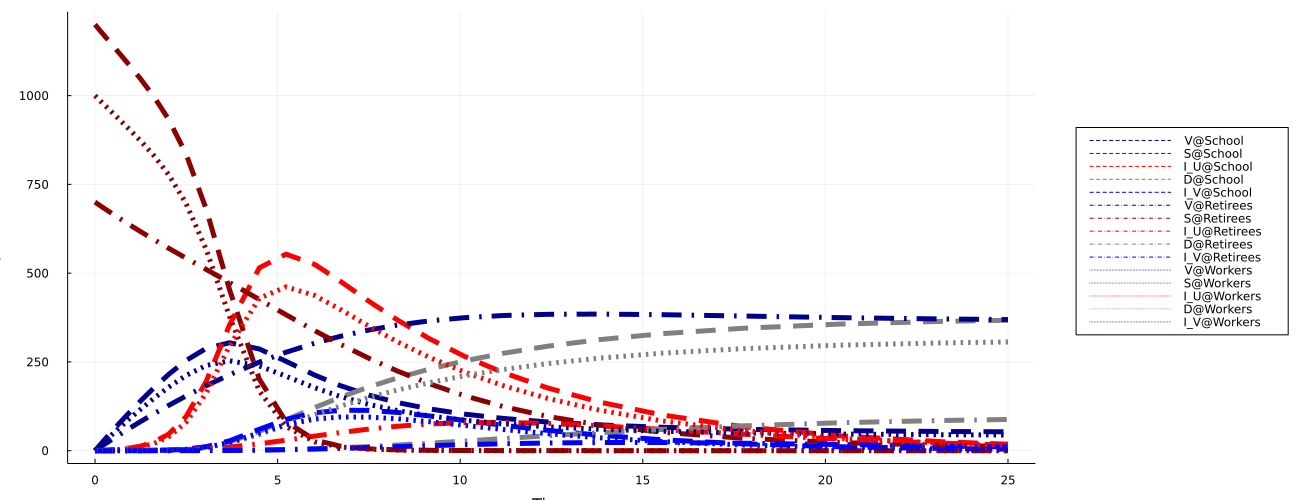

In [37]:
sol = solution(strat_model, (0.0,25.0))
linestyles = Dict("School"=>:dash, "Retirees"=>:dashdot, "Workers"=>:dot)
linecolors = Dict("S"=>:darkred, "V"=>:darkblue, "I_U"=>:red, "I_V"=>:blue, "R"=>:green, "D"=>:gray)

states = ["V", "S", "I_U", "I_V", "D"]
pops = ["School", "Retirees", "Workers"]
names = filter(s ->first(split("$s", "@")) ∈ states && last(split("$s", "@")) ∈ pops,  snames(strat_model))
plot(sol.t, hcat(collect([sol(t)[n] for t in sol.t] for n in names)...); linestyle=reshape([linestyles[last(split("$s", "@"))] for s in names], (1,length(names))),
          color=reshape([linecolors[first(split("$s", "@"))] for s in names], (1,length(names))), labels=reshape(string.(names), (1,length(names))), legend=:outerright, size=(1.3e3,5e2))

In [38]:
fin_met = Sensitivity.final_metric(strat_model, vcat([[Symbol(:D, "@$i")] for i in [:School, :Workers, :Retirees]]...), t_range=(0.0,50.0))
sens = Sensitivity.sensitivity(fin_met, rates(strat_model)) .* rates(strat_model) ./ fin_met(rates(strat_model))
sens *= -1
log_sens = signed_log(sens)
max_rng = maximum(abs.(log_sens))
show_graph(Sensitivity.GraphHeatmap(strat_model, log_sens, clims=(-max_rng, max_rng), positions=str_loc))

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.48.0 (20210717.1556)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- s1 -->
 
 s1 
 
 V@School 
 
<!-- t3 -->
 
 t3 
 
 β_{UV}@School 
 
<!-- s1->t3 -->
 
 s1->t3 
 
 
 1 
 
<!-- t5 -->
 
 t5 
 
 β_{VV}@School 
 
<!-- s1->t5 -->
 
 s1->t5 
 
 
 1 
 
<!-- t36 -->
 
 t36 
 
 crx_V′_I_U_3_1 
 
<!-- s1->t36 -->
 
 s1->t36 
 
 
 1 
 
<!-- t38 -->
 
 t38 
 
 crx_V′_I_V_3_1 
 
<!-- s1->t38 -->
 
 s1->t38 
 
 
 1 
 
<!-- t44 -->
 
 t44 
 
 crx_V′_I_U_2_1 
 
<!-- s1->t44 -->
 
 s1->t44 
 
 
 1 
 
<!-- t46 -->
 
 t46 
 
 crx_V′_I_V_2_1 
 
<!-- s1->t46 -->
 
 s1->t46 
 
 
 1 
 
<!-- s2 -->
 
 s2 
 
 S@School 
 
<!-- t1 -->
 
 t1 
 
 ν@School 
 
<!-- s2->t1 -->
 
 s2->t1 
 
 
 1 
 
<!-- t4 -->
 
 t4 
 
 β_{VU}@School 
 
<!-- s2->t4 -->
 
 s2->t4 
 
 
 1 
 
<!-- t9 -->
 
 t9 
 
 β_{UU}@School 
 
<!-- s2->t9 -->
 
 s2->t9 
 
 
 1 
 
<!-- t37 -->
 
 t37 
 
 crx_S′_I_V_3_1 
 
<!-- s2->t37 -->
 
 s2->t37 
 
 
 1 
 
<!-- t39 -->
 
 t39 
 
 crx_S′_I_U_3_1 
 
<!-- s2->t39 -->
 
 s2->t39 
 
 
 1 
 
<!-- t45 -->
 
 t45 
 
 crx_S′_I_V_2_1 
 
<!-- s2->t45 -->
 
 s2->t45 
 
 
 1 
 
<!-- t47 -->
 
 t47 
 
 crx_S′_I_U_2_1 
 
<!-- s2->t47 -->
 
 s2->t47 
 
 
 1 
 
<!-- s3 -->
 
 s3 
 
 R@School 
 
<!-- s4 -->
 
 s4 
 
 I_U@School 
 
<!-- t2 -->
 
 t2 
 
 δ_U@School 
 
<!-- s4->t2 -->
 
 s4->t2 
 
 
 1 
 
<!-- s4->t3 -->
 
 s4->t3 
 
 
 1 
 
<!-- t7 -->
 
 t7 
 
 γ_U@School 
 
<!-- s4->t7 -->
 
 s4->t7 
 
 
 1 
 
<!-- s4->t9 -->
 
 s4->t9 
 
 
 1 
 
<!-- t40 -->
 
 t40 
 
 crx_V′_I_U_1_2 
 
<!-- s4->t40 -->
 
 s4->t40 
 
 
 1 
 
<!-- t43 -->
 
 t43 
 
 crx_S′_I_U_1_2 
 
<!-- s4->t43 -->
 
 s4->t43 
 
 
 1 
 
<!-- t48 -->
 
 t48 
 
 crx_V′_I_U_1_3 
 
<!-- s4->t48 -->
 
 s4->t48 
 
 
 1 
 
<!-- t51 -->
 
 t51 
 
 crx_S′_I_U_1_3 
 
<!-- s4->t51 -->
 
 s4->t51 
 
 
 1 
 
<!-- s5 -->
 
 s5 
 
 D@School 
 
<!-- s6 -->
 
 s6 
 
 I_V@School 
 
<!-- s6->t4 -->
 
 s6->t4 
 
 
 1 
 
<!-- s6->t5 -->
 
 s6->t5 
 
 
 1 
 
<!-- t6 -->
 
 t6 
 
 δ_V@School 
 
<!-- s6->t6 -->
 
 s6->t6 
 
 
 1 
 
<!-- t8 -->
 
 t8 
 
 γ_V@School 
 
<!-- s6->t8 -->
 
 s6->t8 
 
 
 1 
 
<!-- t41 -->
 
 t41 
 
 crx_S′_I_V_1_2 
 
<!-- s6->t41 -->
 
 s6->t41 
 
 
 1 
 
<!-- t42 -->
 
 t42 
 
 crx_V′_I_V_1_2 
 
<!-- s6->t42 -->
 
 s6->t42 
 
 
 1 
 
<!-- t49 -->
 
 t49 
 
 crx_S′_I_V_1_3 
 
<!-- s6->t49 -->
 
 s6->t49 
 
 
 1 
 
<!-- t50 -->
 
 t50 
 
 crx_V′_I_V_1_3 
 
<!-- s6->t50 -->
 
 s6->t50 
 
 
 1 
 
<!-- s7 -->
 
 s7 
 
 V@Retirees 
 
<!-- t12 -->
 
 t12 
 
 β_{UV}@Retirees 
 
<!-- s7->t12 -->
 
 s7->t12 
 
 
 1 
 
<!-- t14 -->
 
 t14 
 
 β_{VV}@Retirees 
 
<!-- s7->t14 -->
 
 s7->t14 
 
 
 1 
 
<!-- t32 -->
 
 t32 
 
 crx_V′_I_U_3_2 
 
<!-- s7->t32 -->
 
 s7->t32 
 
 
 1 
 
<!-- t34 -->
 
 t34 
 
 crx_V′_I_V_3_2 
 
<!-- s7->t34 -->
 
 s7->t34 
 
 
 1 
 
<!-- s7->t40 -->
 
 s7->t40 
 
 
 1 
 
<!-- s7->t42 -->
 
 s7->t42 
 
 
 1 
 
<!-- s8 -->
 
 s8 
 
 S@Retirees 
 
<!-- t10 -->
 
 t10 
 
 ν@Retirees 
 
<!-- s8->t10 -->
 
 s8->t10 
 
 
 1 
 
<!-- t13 -->
 
 t13 
 
 β_{VU}@Retirees 
 
<!-- s8->t13 -->
 
 s8->t13 
 
 
 1 
 
<!-- t18 -->
 
 t18 
 
 β_{UU}@Retirees 
 
<!-- s8->t18 -->
 
 s8->t18 
 
 
 1 
 
<!-- t33 -->
 
 t33 
 
 crx_S′_I_V_3_2 
 
<!-- s8->t33 -->
 
 s8->t33 
 
 
 1 
 
<!-- t35 -->
 
 t35 
 
 crx_S′_I_U_3_2 
 
<!-- s8->t35 -->
 
 s8->t35 
 
 
 1 
 
<!-- s8->t41 -->
 
 s8->t41 
 
 
 1 
 
<!-- s8->t43 -->
 
 s8->t43 
 
 
 1 
 
<!-- s9 -->
 
 s9 
 
 R@Retirees 
 
<!-- s10 -->
 
 s10 
 
 I_U@Retirees 
 
<!-- t11 -->
 
 t11 
 
 δ_U@Retirees 
 
<!-- s10->t11 -->
 
 s10->t11 
 
 
 1 
 
<!-- s10->t12 -->
 
 s10->t12 
 
 
 1 
 
<!-- t16 -->
 
 t16 
 
 γ_U@Retirees 
 
<!-- s10->t16 -->
 
 s10->t16 
 
 
 1 
 
<!-- s10->t18 -->
 
 s10->t18 
 
 
 1 
 
<!-- t28 -->
 
 t28 
 
 crx_V′_I_U_2_3 
 
<!-- s10->t28 -->
 
 s10->t28 
 
 
 1 
 
<!-- t31 -->
 
 t31 
 
 crx_S′_I_U_2_3 
 
<!-- s10->t31 -->
 
 s10

In [29]:
vax_vals = Highlighter((data, i, j)->(startswith("$(data[i,1])", "ν")), crayon"fg:black bold bg:yellow")
sens_table(sens; highlighters=(vax_vals,))

┌─────────────────┬──────────────┐
│      Transition │  Sensitivity │
├─────────────────┼──────────────┤
│     γ_U@Workers │     0.421181 │
│       ν@Workers │     0.311787 │
│      γ_U@School │     0.155092 │
│      ν@Retirees │     0.151513 │
│        ν@School │    0.0992588 │
│    γ_U@Retirees │    0.0754795 │
│     γ_V@Workers │    0.0336472 │
│    γ_V@Retirees │    0.0144133 │
│      γ_V@School │   0.00941768 │
│  crx_V′_I_V_2_1 │  -2.05481e-7 │
│  crx_S′_I_V_2_1 │  -5.13322e-7 │
│  crx_V′_I_U_2_1 │  -1.44256e-6 │
│  crx_V′_I_V_2_3 │  -1.83681e-6 │
│  crx_S′_I_V_2_3 │  -2.07381e-6 │
│  crx_V′_I_U_2_3 │  -8.24347e-6 │
│  crx_S′_I_U_2_1 │  -1.38176e-5 │
│  crx_S′_I_U_2_3 │  -4.05591e-5 │
│  crx_V′_I_V_3_1 │ -0.000490189 │
│  crx_V′_I_V_1_2 │ -0.000537788 │
│   β_{VV}@School │ -0.000595431 │
│  β_{VV}@Workers │ -0.000987816 │
│  crx_V′_I_V_3_2 │  -0.00109242 │
│  crx_V′_I_V_1_3 │  -0.00120867 │
│ β_{VV}@Retirees │  -0.00207986 │
│  crx_V′_I_U_1_2 │    -0.002899 │
│      δ_V@School │ 

# Acknowledgements

<div><h2>AlgebraicJulia 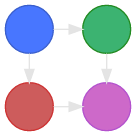</h2> </div>

This library provides the tooling necessary for both the interactive editing of models and the stratification of these models.

<div><h2>SciML 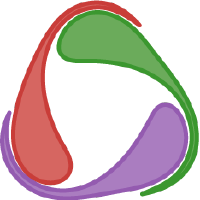</h2> </div>

This library provides the basic sensitivity analysis and simulation tooling.

## Julia Community

This work would not be possible without the high level of work put in to developing the thriving community of Julia developers, especially the developers who are involved in the AlgebraicJulia and SciML projects.

## Relevant Resources

